# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Extra Chapter

In [5]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapterextra()
# This is needed to render the plots in this chapter
from plots.chapterextra import *

/home/dvgodoy/anaconda3/envs/torch/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.datasets import make_regression

from torch.utils.data import DataLoader, TensorDataset
from stepbystep.v3 import StepByStep

from data_generation.ball import load_data

# Vanishing and Exploding Gradients

## Vanishing Gradients

## Ball Dataset and Block Model

In [7]:
X, y = load_data(n_points=1000, n_dims=10)

In [8]:
ball_dataset = TensorDataset(torch.as_tensor(X).float(), torch.as_tensor(y).float())
ball_loader = DataLoader(ball_dataset, batch_size=len(X))

In [9]:
torch.manual_seed(11)
n_layers = 5
n_features = X.shape[1]
hidden_units = 100
activation_fn = nn.ReLU
model = build_model(n_features, n_layers, hidden_units, activation_fn, use_bn=False)

In [10]:
print(model)

Sequential(
  (h1): Linear(in_features=10, out_features=100, bias=True)
  (a1): ReLU()
  (h2): Linear(in_features=100, out_features=100, bias=True)
  (a2): ReLU()
  (h3): Linear(in_features=100, out_features=100, bias=True)
  (a3): ReLU()
  (h4): Linear(in_features=100, out_features=100, bias=True)
  (a4): ReLU()
  (h5): Linear(in_features=100, out_features=100, bias=True)
  (a5): ReLU()
  (o): Linear(in_features=100, out_features=1, bias=True)
)


## Weights, Activations, and Gradients

In [11]:
hidden_layers = [f'h{i}' for i in range(1, n_layers + 1)]
activation_layers = [f'a{i}' for i in range(1, n_layers + 1)]

In [12]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [13]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(ball_loader)
sbs.capture_parameters(hidden_layers)
sbs.capture_gradients(hidden_layers)
sbs.attach_hooks(activation_layers)
sbs.train(1)

In [14]:
parms, gradients, activations = get_plot_data(train_loader=ball_loader, model=model)

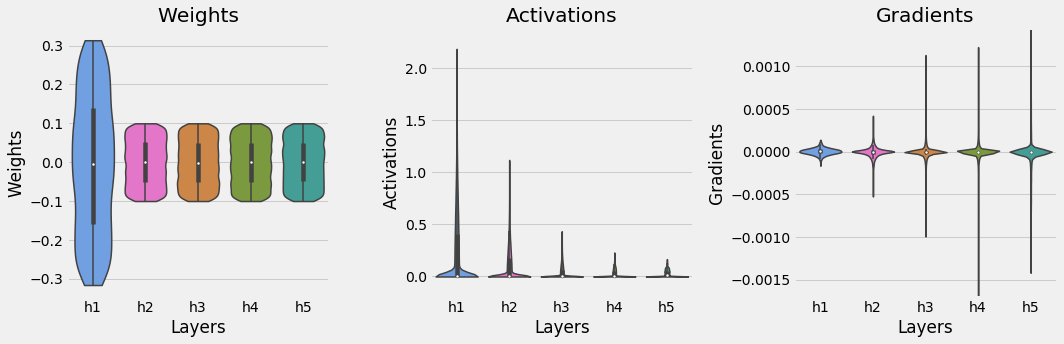

In [15]:
fig = plot_violins(parms, gradients, activations)

## Initialization Schemes

In [16]:
# nn.Linear.reset_parameters
def reset_parameters(self) -> None:
    init.kaiming_uniform_(self.weight, a=math.sqrt(5))
    if self.bias is not None:
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias, -bound, bound)

In [17]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [18]:
with torch.no_grad():
    model.apply(weights_init)

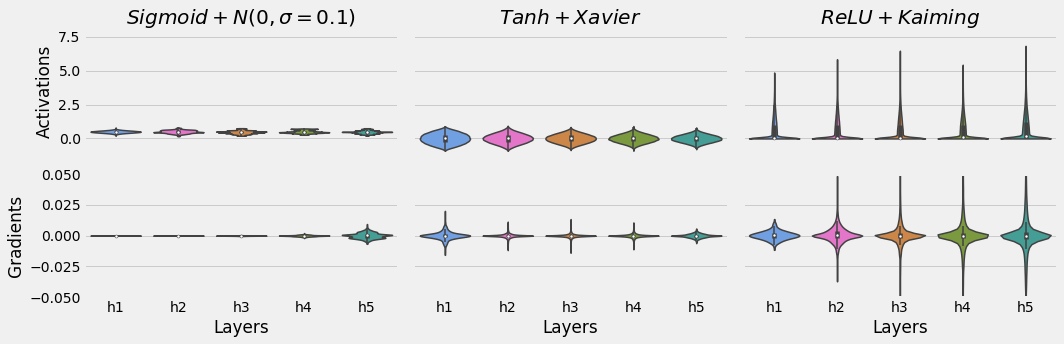

In [19]:
fig = plot_schemes(n_features, n_layers, hidden_units, ball_loader)

## Batch Normalization

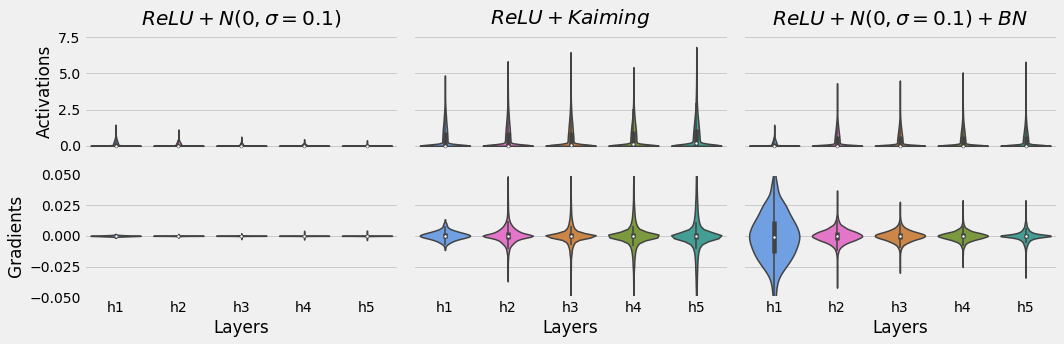

In [20]:
fig = plot_scheme_bn(n_features, n_layers, hidden_units, ball_loader)

## Exploding Gradients

## Data Generation & Preparation

In [21]:
X_reg, y_reg = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

X_reg = torch.as_tensor(X_reg).float()
y_reg = torch.as_tensor(y_reg).float().view(-1, 1)

dataset = TensorDataset(X_reg, y_reg)
train_loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

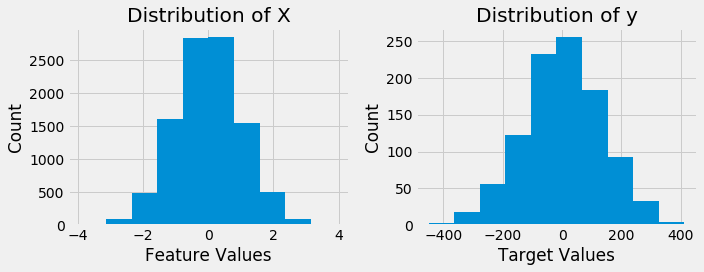

In [22]:
fig = distributions(X_reg, y_reg)

## Model Configuration & Training

In [23]:
torch.manual_seed(11)
model = nn.Sequential()
model.add_module('fc1', nn.Linear(10, 15))
model.add_module('act', nn.ReLU())
model.add_module('fc2', nn.Linear(15, 1))
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [24]:
sbs_reg = StepByStep(model, loss_fn, optimizer)
sbs_reg.set_loaders(train_loader)
sbs_reg.capture_gradients(['fc1'])
sbs_reg.train(2)

In [25]:
sbs_reg.losses

[16985.014358520508, nan]

In [26]:
grads = np.array(sbs_reg._gradients['fc1']['weight'])
print(grads.mean(axis=(1, 2)))

[ 1.58988627e+00 -2.41313894e+00  1.61042006e+00  4.27530414e+00
  2.00876453e+01 -5.46269826e+01  4.76936617e+01 -6.68976169e+01
  4.89202255e+00 -5.48839445e+00 -8.80165010e+00  2.42120121e+01
 -1.95470126e+01 -5.61713082e+00  4.16399702e+01  2.09703794e-01
  9.78054642e+00  8.47080885e+00 -4.37233462e+01 -1.22754592e+01
 -1.05804357e+01  6.17669332e+00 -3.27032627e+00  3.43037068e+01
  6.90878444e+00  1.15130024e+01  8.64732616e+00 -3.04457552e+01
 -3.79791490e+01  1.57137556e+01  1.43945687e+01  8.90063342e-01
 -3.60141261e-01  9.18566430e+00 -7.91019879e+00  1.92959307e+00
 -6.55456380e+00 -1.66785977e+00 -4.13915831e+01  2.03403218e+01
 -5.39869087e+02 -2.33201361e+09  3.74779743e+26             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan         

## Gradient Clipping

In [27]:
torch.manual_seed(42)
parm = nn.Parameter(torch.randn(2, 1))
fake_grads = torch.tensor([[2.5], [.8]])

### Value Clipping

In [28]:
parm.grad = fake_grads.clone()
#Gradient Value Clipping
nn.utils.clip_grad_value_(parm, clip_value=1.0)
parm.grad.view(-1,)

tensor([1.0000, 0.8000])

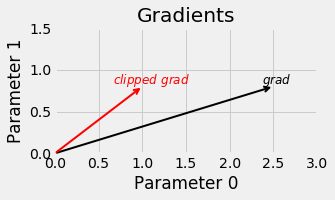

In [31]:
fig = compare_grads(fake_grads, parm.grad)

In [32]:
def clip_backprop(model, clip_value):
    handles = []
    for p in model.parameters():
        if p.requires_grad:
            func = lambda grad: torch.clamp(grad, 
                                            -clip_value,
                                            clip_value)
            handle = p.register_hook(func)
            handles.append(handle)
    return handles

### Norm Clipping

In [33]:
parm.grad = fake_grads.clone()
# Gradient Norm Clipping
nn.utils.clip_grad_norm_(parm, max_norm=1.0, norm_type=2)
fake_grads.norm(), parm.grad.view(-1,), parm.grad.norm()

(tensor(2.6249), tensor([0.9524, 0.3048]), tensor(1.0000))

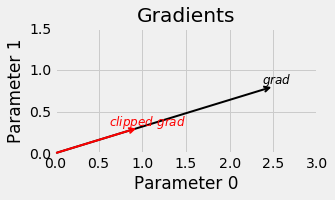

In [34]:
fig = compare_grads(fake_grads, parm.grad)

In [35]:
setattr(StepByStep, 'clipping', None)

def set_clip_grad_value(self, clip_value):
    self.clipping = lambda: nn.utils.clip_grad_value_(self.model.parameters(), clip_value=clip_value)
    
def set_clip_grad_norm(self, max_norm, norm_type=2):
    self.clipping = lambda: nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=max_norm, norm_type=norm_type)
    
def remove_clip(self):
    self.clipping = None

def _make_train_step(self):
    # This method does not need ARGS... it can refer to
    # the attributes: self.model, self.loss_fn and self.optimizer

    # Builds function that performs a step in the train loop
    def perform_train_step(x, y):
        # Sets model to TRAIN mode
        self.model.train()

        # Step 1 - Computes our model's predicted output - forward pass
        yhat = self.model(x)
        # Step 2 - Computes the loss
        loss = self.loss_fn(yhat, y)
        # Step 3 - Computes gradients
        loss.backward()

        if callable(self.clipping):
            self.clipping()
        
        # Step 4 - Updates parameters using gradients and learning rate
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    # Returns the function that will be called inside the train loop
    return perform_train_step

setattr(StepByStep, 'set_clip_grad_value', set_clip_grad_value)
setattr(StepByStep, 'set_clip_grad_norm', set_clip_grad_norm)
setattr(StepByStep, 'remove_clip', remove_clip)
setattr(StepByStep, '_make_train_step', _make_train_step)

In [36]:
def set_clip_backprop(self, clip_value):
    if self.clipping is None:
        self.clipping = []
    for p in self.model.parameters():
        if p.requires_grad:
            func = lambda grad: torch.clamp(grad, -clip_value, clip_value)
            handle = p.register_hook(func)
            self.clipping.append(handle)

def remove_clip(self):
    if isinstance(self.clipping, list):
        for handle in self.clipping:
            handle.remove()
    self.clipping = None

setattr(StepByStep, 'set_clip_backprop', set_clip_backprop)
setattr(StepByStep, 'remove_clip', remove_clip)

## Model Configuration & Training

In [37]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [38]:
torch.manual_seed(42)
with torch.no_grad():
    model.apply(weights_init)
    
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [39]:
sbs_reg_clip = StepByStep(model, loss_fn, optimizer)
sbs_reg_clip.set_loaders(train_loader)
sbs_reg_clip.set_clip_grad_value(1.0)
sbs_reg_clip.capture_gradients(['fc1'])
sbs_reg_clip.train(10)
sbs_reg_clip.remove_clip()
sbs_reg_clip.remove_hooks()

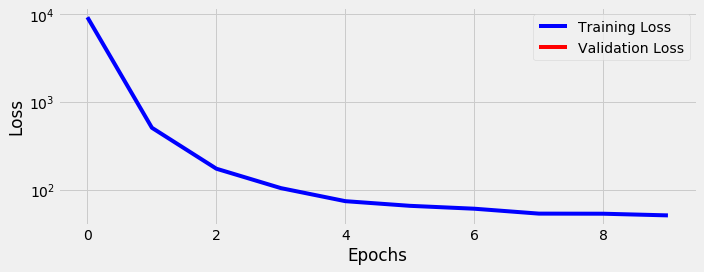

In [40]:
fig = sbs_reg_clip.plot_losses()

In [41]:
avg_grad = np.array(sbs_reg_clip._gradients['fc1']['weight']).mean(axis=(1, 2))
avg_grad.min(), avg_grad.max()

(-24.69288555463155, 14.385948762893676)

## Clipping with Hooks

In [42]:
torch.manual_seed(42)
with torch.no_grad():
    model.apply(weights_init)

In [43]:
sbs_reg_clip_hook = StepByStep(model, loss_fn, optimizer)
sbs_reg_clip_hook.set_loaders(train_loader)
sbs_reg_clip_hook.set_clip_backprop(1.0)
sbs_reg_clip_hook.capture_gradients(['fc1'])
sbs_reg_clip_hook.train(10)
sbs_reg_clip_hook.remove_clip()
sbs_reg_clip_hook.remove_hooks()

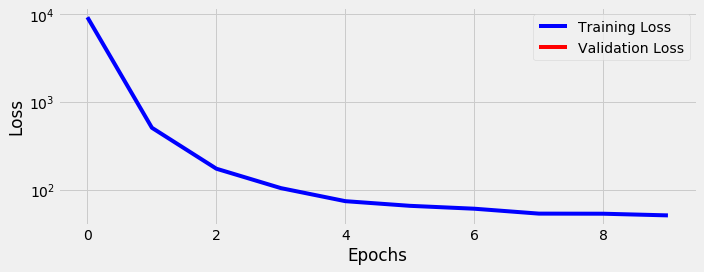

In [44]:
fig = sbs_reg_clip_hook.plot_losses()

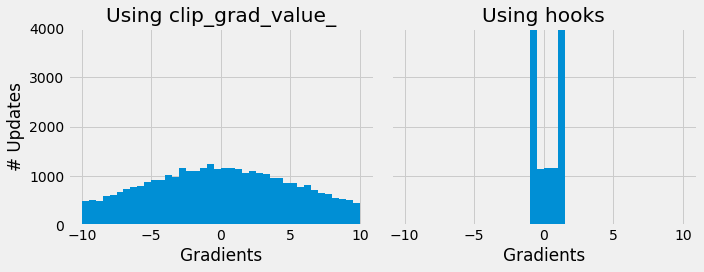

In [45]:
fig = gradient_distrib(sbs_reg_clip, 'fc1', sbs_reg_clip_hook, 'fc1')